#Guided SmoothGrad (Smoothgrad + Guided-backpropagation)

### Essential libraries

In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

### VGG16 model and preprocessing

In [2]:
# Load the pre-trained VGG16 model
model = models.vgg16(pretrained=True)
model.eval()

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 125MB/s]


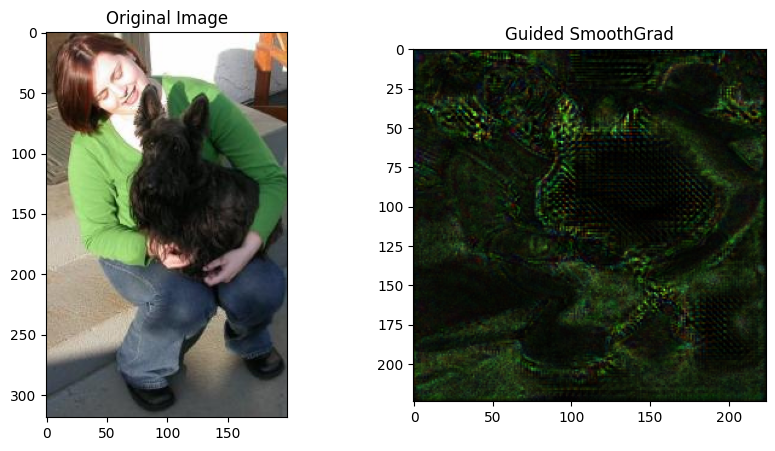

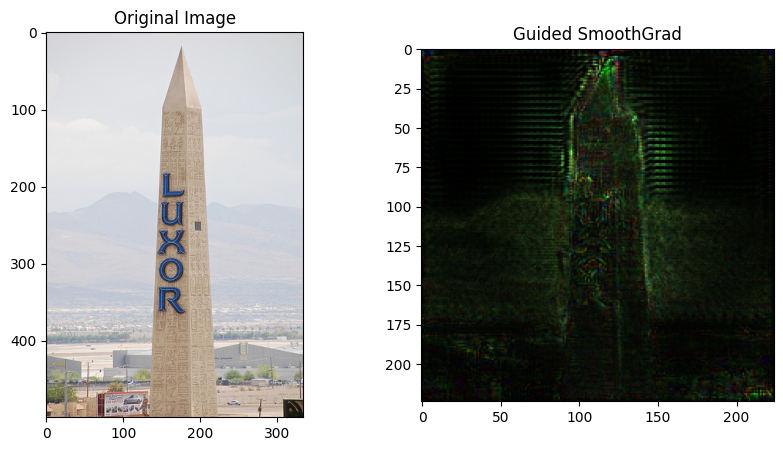

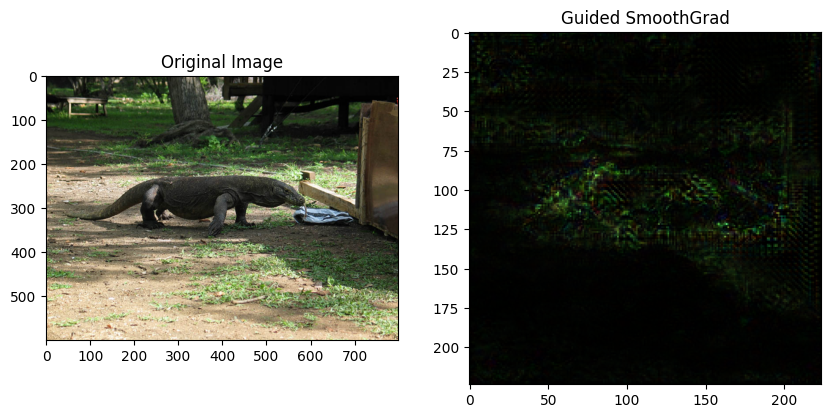

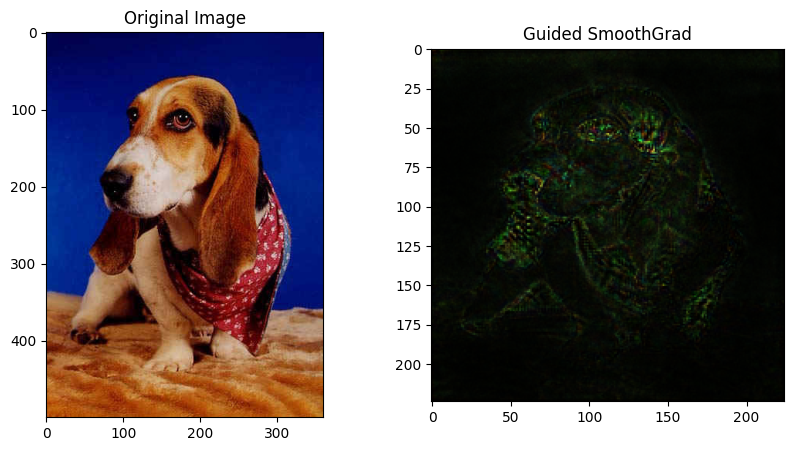

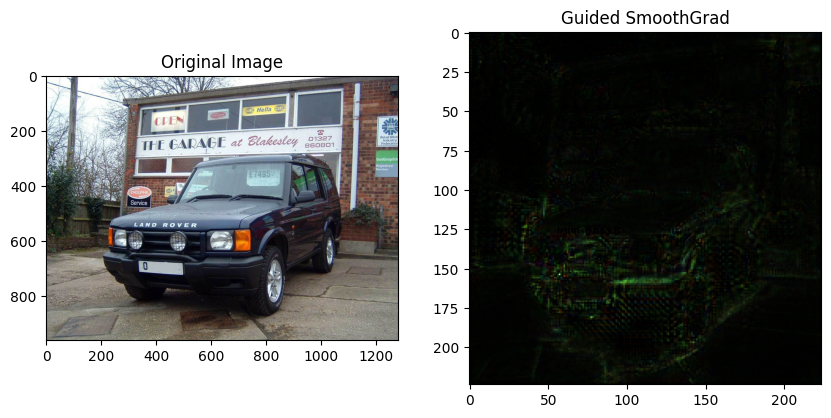

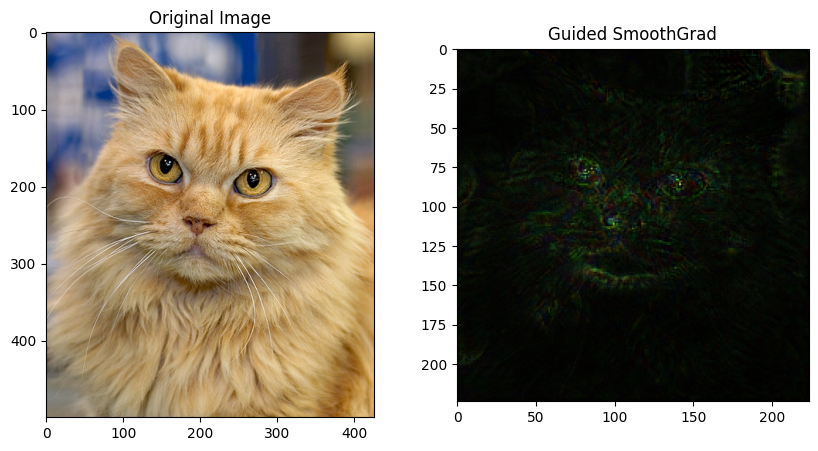

In [3]:
# Function for Guided Backpropagation
def guided_backprop(model, image, target_class):
    image_tensor = preprocess(image).unsqueeze(0)
    image_tensor.requires_grad = True

    model.zero_grad()
    output = model(image_tensor)
    target = output[0][target_class]
    target.backward()

    grad = image_tensor.grad.data[0].cpu().numpy()
    grad = np.maximum(grad, 0)  # Apply ReLU to gradients

    return grad

# Function for SmoothGrad
def smooth_grad(model, image, target_class, n_samples=50, noise_level=0.2):
    image_np = np.array(image).astype(np.float32) / 255.0
    image_np = preprocess(image).unsqueeze(0).numpy()
    smooth_grad = np.zeros_like(image_np)

    for i in range(n_samples):
        noisy_image_np = image_np + np.random.normal(0, noise_level, image_np.shape)
        noisy_image_np = np.clip(noisy_image_np, 0, 1)
        noisy_image = torch.tensor(noisy_image_np).float()
        noisy_image = noisy_image.squeeze(0)
        noisy_image_pil = transforms.ToPILImage()(noisy_image)
        grad = guided_backprop(model, noisy_image_pil, target_class)
        smooth_grad += grad

    smooth_grad /= n_samples
    return smooth_grad

# Function to display the results
def display_results(image_path, target_class):
    image = Image.open(image_path).convert('RGB')
    result = smooth_grad(model, image, target_class)

    # Normalize the result for better visualization
    result = result - result.min()
    result = result / result.max()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    result = np.transpose(result[0], (1, 2, 0))
    plt.imshow(result)
    plt.title('Guided SmoothGrad')
    plt.show()

image_paths = [
    '/content/n02097298_Scotch_terrier.JPEG',
    '/content/n03837869_obelisk.JPEG',
    '/content/n01695060_Komodo_dragon.JPEG',
    '/content/n02088238_basset.JPEG',
    '/content/n03594945_jeep.JPEG',
    '/content/n02123394_Persian_cat.JPEG'
]

target_classes = [
    109,  # Scotch terrier
    538,  # Obelisk
    473,  # Komodo dragon
    161,  # Basset
    609,  # Jeep
    283   # Persian cat
]

# Generate and display results for each image
for image_path, target_class in zip(image_paths, target_classes):
    display_results(image_path, target_class)
